# Caffein-AI-tor

Double Deep Learning CNN's with Face and Emotion recognition, feeding predictive Machine Learning, to bring you the optimal Caffeine kick.

# The Webcam interface
Here we set up the interface to the webcam. It uses the OpenCV module to access the camera. As the webcam buffers several frames, we'll use the Python Threading module to continuously read the webcam, so we always have a fresh frame!

In [1]:
from threading import Thread
import cv2

class WebcamVideoStream:
    def __init__(self, src=0, width = 1920, height = 1080, name="WebcamVideoStream"):
        # initialize the video camera stream and read the first frame
        # from the stream
        self.stream = cv2.VideoCapture(src)

        self.stream.set(cv2.CAP_PROP_FRAME_WIDTH,width)
        self.stream.set(cv2.CAP_PROP_FRAME_HEIGHT,height)
        
        (self.grabbed, self.frame) = self.stream.read()

        # initialize the thread name
        self.name = name

        # initialize the variable used to indicate if the thread should
        # be stopped
        self.stopped = False

    def start(self):
        # start the thread to read frames from the video stream
        t = Thread(target=self.update, name=self.name, args=())
        t.daemon = True
        t.start()
        return self

    def update(self):
        # keep looping infinitely until the thread is stopped
        while True:
            # if the thread indicator variable is set, stop the thread
            if self.stopped:
                return

            # otherwise, read the next frame from the stream
            (self.grabbed, self.frame) = self.stream.read()

    def read(self):
        # return the frame most recently read
        return self.frame

    def stop(self):
        # indicate that the thread should be stopped
        self.stopped = True 
        
    def end(self):
        # release the camera
        self.stream.release()

In [2]:
# Instantiate the camera, and start it up
video = WebcamVideoStream()
video.start()

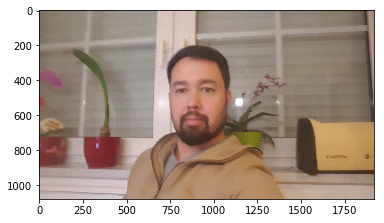

In [7]:
#Load up the Matplotlib display module
import matplotlib.pyplot as plt
%matplotlib inline

# Grab a frame, convert it to RGB format and display it
frame_in = video.read()
frame_rgb = cv2.cvtColor(frame_in, cv2.COLOR_BGR2RGB)    # makes the blues image look real colored
webcam_preview = plt.imshow(frame_rgb)
face_img = frame_in

# Programmable Logic overlay for Blur Detection
Here we program the overlay on the FPGA, load the associated overlay library and load the PYNQ xlnk memory manager library. This process takes a few seconds to do. Overlays are generally composed of an FPGA bitstream and a shared library to access the accelerators via function calls. We use the pynq.Bitstream class to load the overlay and rename the associated shared library to xv2. It is also important to set the xlnk allocator library to point the same shared library so allocated memory maps are consistent. The pynq.Xlnk class contains hooks to the SDx memory allocation functions which is important when allocating certain kinds of memory for our accelerators (e.g. continguous non-cacheable buffers)

In [9]:
# Load filter2D + dilate overlay
from pynq import Bitstream
bs = Bitstream("/usr/local/lib/python3.6/dist-packages/pynq_cv/overlays/xv2Filter2DDilate.bit")
bs.download()
import pynq_cv.overlays.xv2Filter2DDilate as xv2

# Load xlnk memory mangager
from pynq import Xlnk
Xlnk.set_allocator_library('/usr/local/lib/python3.6/dist-packages/pynq_cv/overlays/xv2Filter2DDilate.so')
mem_manager = Xlnk()

In [18]:
# import the greatest array module ever!
import numpy as np

# Image size
width = 1920
height = 1080

#laplacian filter
kernel = np.array([[0.0, 1.0, 0],[1.0,-4,1.0],[0,1.0,0.0]],np.float32)
xFin       = mem_manager.cma_array((height,width),np.uint8)
xFout      = mem_manager.cma_array((height,width),np.uint8)

### Test on a sharp image

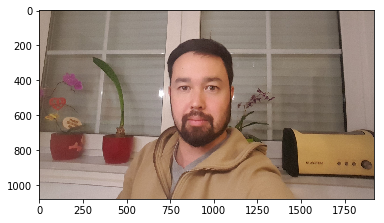

In [21]:
# Grab a frame, convert it to RGB format and display it
frame_in = video.read()
frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)    # makes the blues image look real colored
webcam_preview = plt.imshow(frame_rgb) 
sharp_image = frame_in

Laplacian Variance is:  18.83808737740409


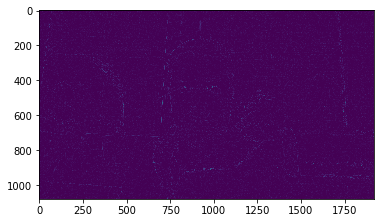

In [30]:
frame_in_gray = cv2.cvtColor(frame_in,cv2.COLOR_RGB2GRAY)

xFin[:]    = frame_in_gray[:]

xv2.filter2D(xFin, -1, kernel, xFout, borderType=cv2.BORDER_CONSTANT)

frame_out = np.ones((height,width),np.uint8)
frame_out[:] = xFout[:]
plt.imshow(frame_out)
print("Laplacian Variance is: ",frame_out.var())

### Test on a blurry image

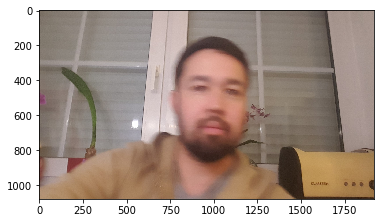

In [31]:
# Grab a frame, convert it to RGB format and display it
frame_in = video.read()
frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)    # makes the blues image look real colored
webcam_preview = plt.imshow(frame_rgb) 
blurry_image = frame_in

Laplacian Variance is:  14.040861456472564


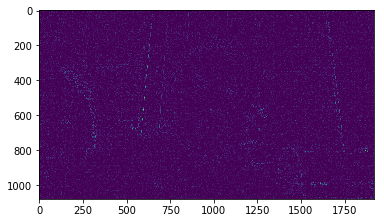

In [34]:
frame_in_gray = cv2.cvtColor(frame_in,cv2.COLOR_RGB2GRAY)

xFin[:]    = frame_in_gray[:]

xv2.filter2D(xFin, -1, kernel, xFout, borderType=cv2.BORDER_CONSTANT)

frame_out = np.ones((height,width),np.uint8)
frame_out[:] = xFout[:]
plt.imshow(frame_out)
print("Laplacian Variance is: ",frame_out.var())

### Laplacian Variance for blur detection
As a face only takes up about a 5th of the frame, the effect of motion blur on the overall variance isn't huge, but its enough to discern a blurry face. We'll use a cutoff of 16 to decide that an image is sharp.

## Face Detection
We look for a face with a Haar Feature-based Cascade Classifiers. 

In [10]:
# load the detector
haar_face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

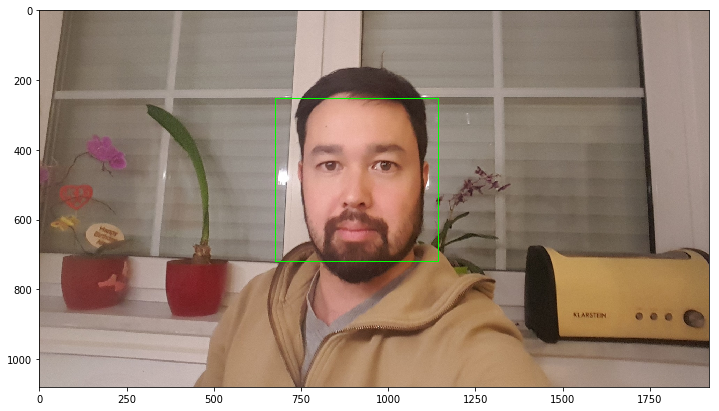

In [8]:
face_frame = np.copy(sharp_image)
faces = haar_face_cascade.detectMultiScale(face_frame[:,:,1], scaleFactor=1.1, minSize= (400,400) , minNeighbors=5)
#go over list of faces and draw them as rectangles on original colored img 
for (x, y, w, h) in faces:     
    cv2.rectangle(face_frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
plt.figure(figsize=(12,8))
plt.imshow(cv2.cvtColor(face_frame, cv2.COLOR_BGR2RGB))

In [90]:
faces

array([[678, 253, 467, 467]], dtype=int32)

# Face Recognition
Our first CNN, used to get a facial 'Fingerprint' to identify users

In [198]:
# Load the CNN
facenet = cv2.dnn.readNetFromCaffe('bvlc_googlenet.prototxt', 'bvlc_googlenet.caffemodel')

In [200]:
# the CNN takes an input image of 224x224 pixel, so we have to resize the cropped face
face_crop = sharp_image[faces[0][1]:faces[0][1] + faces[0][3], faces[0][0]:faces[0][0] + faces[0][2], :]
faceblob = cv2.dnn.blobFromImage(face_crop, 1, (224, 224))

In [234]:
# Load the Time module
import time

# set the blob as input to the network and perform a forward-pass to
# obtain our output classification
facenet.setInput(faceblob)
start = time.time()
facenet_fingerprint = facenet.forward()
end = time.time()
print("[INFO] classification took {:.5} seconds".format(end - start))

[INFO] classification took 0.064824 seconds


[[2.82528927e-05 4.38441493e-05 8.89229923e-05 2.11622144e-04
  2.88649662e-05 4.80312156e-06 6.23193264e-05 8.71144948e-06
  3.70945190e-06 1.83526140e-06 1.73762066e-06 9.02410079e-07
  3.70483826e-06 1.94813742e-06 8.26469295e-06 1.05131210e-06
  3.49956827e-06 5.00872784e-06 1.69647756e-05 1.14423653e-06
  8.18920455e-07 5.92380786e-07 1.28596203e-05 8.78754781e-06
  7.27866063e-06 3.98783368e-06 2.12302825e-06 8.49677599e-05
  5.61020279e-05 5.60134595e-06 1.68265924e-05 2.41214693e-05
  1.57900831e-05 5.43585429e-06 2.04045273e-06 9.38625180e-06
  2.70156179e-05 1.56361857e-05 5.16311884e-05 4.42073288e-05
  7.35770227e-05 4.11519022e-06 1.73102526e-05 1.16842539e-05
  1.62097022e-05 9.50234789e-06 2.71936500e-04 3.53356518e-05
  4.97008114e-06 1.65185452e-06 1.50917649e-05 1.13476981e-05
  1.56098886e-05 3.07926312e-05 2.00132363e-05 3.33990829e-05
  2.72043017e-05 1.93000938e-06 1.25017068e-05 3.04161003e-05
  1.82805143e-05 2.11048955e-05 4.40903386e-06 1.91501804e-05
  1.3729

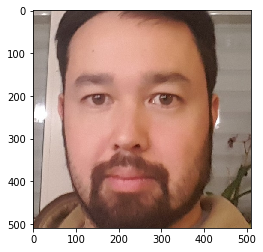

In [203]:
# Face and encoding
plt.imshow(cv2.cvtColor(face_crop, cv2.COLOR_BGR2RGB))
print(facenet_prediction)

# Emotion Recognition
Our second CNN, used to get a facial emotion estimation

In [211]:
# Load the CNN
emonet = cv2.dnn.readNetFromCaffe('EmotiW_VGG_S.prototxt', 'EmotiW_VGG_S.caffemodel')

In [35]:
# the CNN takes an input image of 224x224 pixel in RGB, so we have to resize the cropped face
face_crop = sharp_image[faces[0][1]:faces[0][1] + faces[0][3], faces[0][0]:faces[0][0] + faces[0][2], :]
emoblob = cv2.dnn.blobFromImage(cv2.cvtColor(face_crop, cv2.COLOR_BGR2RGB), 1, (224, 224))

In [36]:
# set the blob as input to the network and perform a forward-pass to
# obtain our output classification
emonet.setInput(emoblob)
start = time.time()
emo_prediction = emonet.forward()
end = time.time()
print("[INFO] classification took {:.5} seconds".format(end - start))

[INFO] classification took 0.16556 seconds


array([[8.5142106e-03, 3.4469385e-03, 6.3360161e-01, 9.0195870e-05,
        3.4103855e-01, 1.3467383e-04, 1.3173814e-02]], dtype=float32)

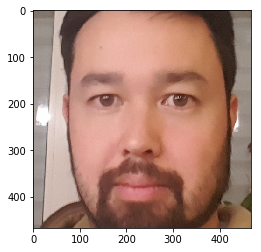

In [37]:
plt.imshow(cv2.cvtColor(face_crop, cv2.COLOR_BGR2RGB))
emo_prediction

# Classifying Users
Here we will detect the users from the list of previously seen people

In [65]:
# People we know
known_faces = []
cutoff = 0.4

In [66]:
# Fancy list-comprehension to find the position of the face in the list if ints known
postion = [i for i,face_encodings in enumerate(known_faces) if np.linalg.norm(face_encodings[0] - facenet_fingerprint, axis=1) < cutoff]

# Predicting the Coffee Selection
Time for Random Forest machine learning for coffee classification!

In [67]:
#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier

In [68]:
#import time info for another feature (stronger coffee in the morning?)
from datetime import datetime

# the feature is called time_fraction, and is a percentage of the day used. Floats make machine learning happy!
now = datetime.now()
seconds_since_midnight = (now - now.replace(hour=0, minute=0, second=0, microsecond=0)).total_seconds()
time_fraction = seconds_since_midnight / (24 * 60 *60)

In [153]:
# if we don't know the user yet, we can store the data for later predictions
if not postion:
    print('1 for Espresso')
    print('2 for Latte')
    print('3 for Cappucchino')
    print('4 for Americano')
    selection = int(input("Enter your Coffee Selection:"))
    print()
    print('Features and Result stored')
    known_faces.append([facenet_fingerprint,[(np.append(emo_prediction[0], time_fraction), selection)]])

else:
    # Otherwise, take a guess at what they want!

    #Build Training data
    feature = np.zeros((len(known_faces[postion[0]][1]),8))
    outcomes = np.zeros((len(known_faces[postion[0]][1])), dtype=int)
    for i, sample in enumerate(known_faces[postion[0]][1]):
        feature[i, :] = sample[0]
        outcomes[i] = int(sample[1])

    #Create a Gaussian Classifier
    classifier = RandomForestClassifier()

    #Train the model using the training sets y_pred=clf.predict(X_test)
    classifier.fit(feature,outcomes)

    input_data = np.append(emo_prediction[0], time_fraction)
    input_data = input_data.reshape(-1, input_data.shape[0])
    y_pred = classifier.predict(input_data)[0]

    options = ['Espresso', 'Latte', 'Cappucchino', 'Americano']

    print("I'm guessing you want a ", options[y_pred - 1])
    selection = input("Did I get it right? (y/n):")

    if selection == 'y':
        print('Preparing you a', options[y_pred - 1])
        selection = y_pred - 1
    else:
        print('1 for Espresso')
        print('2 for Latte')
        print('3 for Cappucchino')
        print('4 for Americano')
        selection = int(input("Enter your Coffee Selection:"))
        print('Preparing you a', options[selection - 1])

    # Update our data to improve the machine learning next time!    
    known_faces[postion[0]][1].append((np.append(emo_prediction[0], time_fraction), selection))

I'm guessing you want a  Espresso
Did I get it right? (y/n):y
Preparing you a Espresso


# Controlling the Coffee Machine
We can now use the linux access to the PS GPIOs to control the coffee machine, as described in the Project Outline!

I hope you learnt a bit about AI on the Edge with this project! I'm excited to see how you incorporate this technology into your own projects!
